In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load Recast Data

In [2]:
# Load models (axial and vector)
inputFiles = ['../scanResults_axial.pcl', '../scanResults_vector.pcl']
dfs = [pd.read_pickle(i) for i in inputFiles]
recastData = pd.concat(dfs, ignore_index=True)
# inputFile = '../scanResults_axial.pcl'
# recastData = pd.read_pickle(inputFile)

### Get model points

In [28]:
models = []
mCols = ['Coupling', 'Mode', '$m_{med}$', '$m_{DM}$']
for row in recastData[mCols].values:
    m = dict(zip(mCols, row.tolist()))
    if m not in models:
        models.append(m)

print('%i models loaded.' %len(models))

353 models loaded.


### Get model parameters

In [4]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]
print(parameters)

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in ['$m_{med}$','$m_{DM}$']])
print(textstr)

{'Coupling': ['Vector', 'Axial'], 'Mode': 'DM+QCDjets', '$m_{med}$': [450.0, 1250.0, 100.0, 2500.0, 200.0, 1000.0, 2250.0, 300.0, 750.0, 400.0, 2000.0, 500.0, 1750.0, 3000.0, 250.0, 1500.0, 2750.0], '$m_{DM}$': [1.0, 900.0, 1400.0, 650.0, 400.0, 150.0, 30.0, 800.0, 40.0, 300.0, 45.0, 1200.0, 50.0, 55.0, 700.0, 60.0, 450.0, 70.0, 200.0, 75.0, 1100.0, 80.0, 600.0, 90.0, 1500.0, 350.0, 100.0, 1000.0, 750.0, 500.0, 120.0, 250.0]}
Coupling = ['Vector', 'Axial']
Mode = DM+QCDjets


### Obtain Efficiencies

In [5]:
label = [c for c in recastData if (c.startswith("bin_") and not 'Error' in c)]
labelEff = [l+'_Efficiency' for l in label]

In [6]:
# Obtain efficiency: e = ns/(xsec*lumi)
eff = []

for i, l in enumerate(label):
    e = []
    for i in range(len(models*3)): 
        xsec = recastData['Total xsec (pb)'].iloc[i]
        lumi = recastData['Luminosity (1/fb)'].iloc[i]
        ns = recastData[l].iloc[i]
        e.append(ns/(xsec*lumi))
    eff.append(e)
        
for i, l in enumerate(labelEff):
    recastData[l] = eff[i]

In [7]:
recastData['Median_efficiency'] = recastData[labelEff].median(axis=1)

In [8]:
recastData.T

,0,1,2,3,4,5,6,7,8,9,...,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058
Coupling,Axial,Axial,Axial,Axial,Axial,Axial,Axial,Axial,Axial,Axial,...,Vector,Vector,Vector,Vector,Vector,Vector,Vector,Vector,Vector,Vector
Mode,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,...,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets
$m_{med}$,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0
$m_{DM}$,1.0,1.0,1.0,30.0,30.0,30.0,40.0,40.0,40.0,45.0,...,200.0,400.0,400.0,400.0,600.0,600.0,600.0,800.0,800.0,800.0
Data-takingperiod,2018,2017,2016,2018,2017,2016,2018,2017,2016,2018,...,2016,2018,2017,2016,2018,2017,2016,2018,2017,2016
Luminosity (1/fb),59.7,41.5,36.0,59.7,41.5,36.0,59.7,41.5,36.0,59.7,...,36.0,59.7,41.5,36.0,59.7,41.5,36.0,59.7,41.5,36.0
bin_250.0_280.0,286905.208738,240787.371388,206492.876967,214633.630837,161500.667368,170436.137733,99672.148518,94379.37172,81870.901446,60137.893372,...,20.529391,22.619044,15.934814,17.147999,17.799901,19.164583,14.890008,16.019797,13.013723,15.542462
bin_250.0_280.0_ErrorPlus,29183.256528,22713.165305,20176.708075,17564.330177,15686.0483,18663.045546,10149.955516,8755.16385,8288.739339,4703.134655,...,1.965085,1.960423,1.732065,1.703009,1.758805,1.846411,1.542432,1.578038,1.427561,1.575317
bin_250.0_280.0_ErrorMinus,29183.256528,22713.165305,20176.708075,17564.330177,15686.0483,18663.045546,10149.955516,8755.16385,8288.739339,4703.134655,...,1.965085,1.960423,1.732065,1.703009,1.758805,1.846411,1.542432,1.578038,1.427561,1.575317
bin_280.0_310.0,157920.384831,153165.945145,115768.035,123680.338301,90135.844223,104970.863918,63980.249622,57839.03097,43368.090672,34810.354137,...,11.114587,18.035436,13.59583,11.179169,17.688171,10.625521,13.018402,13.802646,14.246209,10.851268


In [9]:
recastData = recastData[recastData['Data-takingperiod'] == 2017]

In [36]:
# Guarantees common models

dataAx = recastData[recastData['Coupling'] == 'Axial']
dataVec = recastData[recastData['Coupling'] == 'Vector']

keys = list(dataVec[mCols].columns.values)
i1 = dataAx.set_index(keys).index
i2 = dataVec.set_index(keys).index
dataAx = dataAx[i1.isin(i2)]
dataVec = dataVec[i2.isin(i1)]

176 176


### Map Efficiencies for one coupling

In [19]:
recastData = recastData[recastData['Coupling'] == 'Axial']

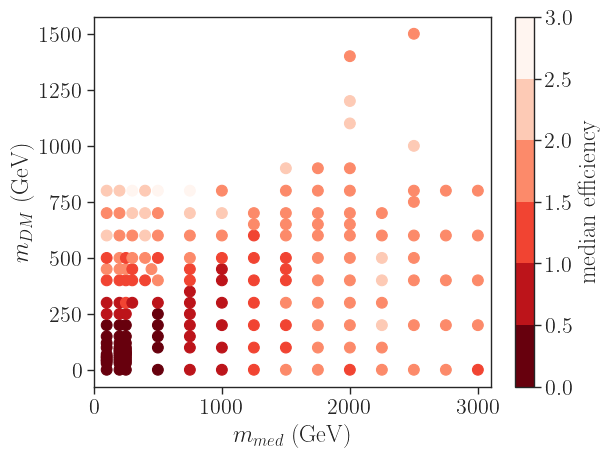

In [28]:
plt.scatter(x=recastData['$m_{med}$'], y=recastData['$m_{DM}$'], vmin=0., vmax=3., 
            c=recastData['Median_efficiency'], cmap=plt.cm.get_cmap('Reds_r', 6),
            s=60)

cbar = plt.colorbar(label='median efficiency')

plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
# plt.ylim(-10,1500)
plt.show()

In [36]:
pts = np.array([x for x in product(np.linspace(0.,3000.,100),np.linspace(0.,1500.,100))])
medEffPts = griddata(list(zip(recastData['$m_{med}$'],recastData['$m_{DM}$'])),
                  recastData['Median_efficiency'],pts)
pts = pts[~np.isnan(medEffPts)]
medEffPts = medEffPts[~np.isnan(medEffPts)]

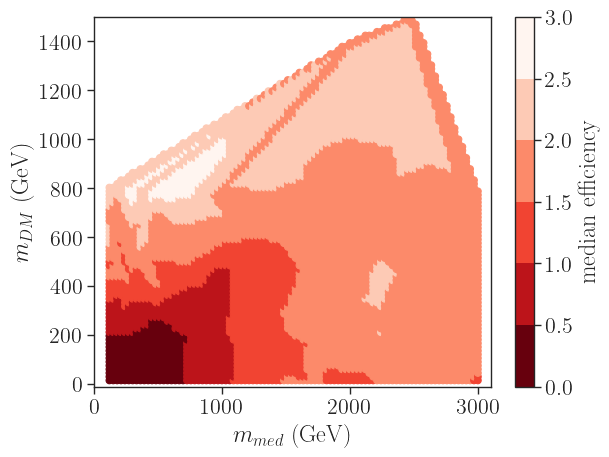

In [37]:
plt.scatter(x=pts[:,0], y=pts[:,1], vmin=0., vmax = 3., 
            c=medEffPts, cmap=plt.cm.get_cmap('Reds_r',6))
cbar = plt.colorbar(label='median efficiency')
plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
plt.ylim(-10,1500)
plt.show()